In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

## Encoding categorical variables

In [3]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [4]:
# For "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Selecting only the needed features
df_cct = df_cct[['Card', 'Month', 'Day', 'Hours', 'Amount', 'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'Retired', 'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',
       'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday','Is Fraud?']]

## Imbalanced dataset

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df_cct['Is Fraud?'].value_counts()[0]/len(df_cct) * 100,2), '% of the dataset')
print('Frauds', round(df_cct['Is Fraud?'].value_counts()[1]/len(df_cct) * 100,2), '% of the dataset')

No Frauds 99.88 % of the dataset
Frauds 0.12 % of the dataset


## Scaling and Distributing

In [7]:

# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', RobustScaler(), ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',])
        ])

preprocessor.fit_transform(df_cct)

array([[-0.5       ,  0.28571429, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5       ,  0.28571429, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5       ,  0.28571429, -0.93333333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.71428571,  0.8       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.71428571,  0.8       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.71428571,  0.8       , ...,  0.        ,
         0.        ,  0.        ]])

In [8]:
df_cct.columns

Index(['Card', 'Month', 'Day', 'Hours', 'Amount', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'Is Fraud?'],
      dtype='object')

In [9]:
df_cct[['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Retired',
       'bad_pin', 'insufficient_balance', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
        'Is Fraud?']] = preprocessor.fit_transform(df_cct)

## Splitting the original dataset

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df_cct['Is Fraud?'].value_counts()[0]/len(df_cct) * 100,2), '% of the dataset')
print('Frauds', round(df_cct['Is Fraud?'].value_counts()[1]/len(df_cct) * 100,2), '% of the dataset')

X = df_cct.drop('Is Fraud?', axis=1)
y = df_cct['Is Fraud?']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.88 % of the dataset
Frauds 0.12 % of the dataset
Train: [ 4876906  4876907  4876908 ... 24386897 24386898 24386899] Test: [      0       1       2 ... 5236157 5236158 5236170]
Train: [       0        1        2 ... 24386897 24386898 24386899] Test: [4876906 4876907 4876908 ... 9933403 9933404 9933405]
Train: [       0        1        2 ... 24386897 24386898 24386899] Test: [ 9754504  9754505  9754506 ... 14719660 14719672 14719674]
Train: [       0        1        2 ... 24386897 24386898 24386899] Test: [14632023 14632024 14632025 ... 19509718 19509719 19509720]
Train: [       0        1        2 ... 19509718 19509719 19509720] Test: [19390808 19401403 19401404 ... 24386897 24386898 24386899]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99877983 0.00122017]
[0.99877967 0.00122033]


## Random Under-sampling

In [11]:

# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df_cct = df_cct.sample(frac=1)

# amount of fraud classes 29,757 rows.
fraud_df = df_cct.loc[df_cct['Is Fraud?'] == 1]
non_fraud_df = df_cct.loc[df_cct['Is Fraud?'] == 0][:29757]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Card,Month,Day,Hours,Amount,delta_t_s,delta_t_s_card,amt/daily_income,Retired,daily_amount,...,Online Transaction,Swipe Transaction,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Is Fraud?
10409022,0.0,0.571429,0.600000,-0.571429,1.195310,-0.336750,-0.402191,0.924153,0.0,1.582133,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9684831,1.5,-0.285714,-0.800000,0.000000,-0.228428,-0.303075,-0.384194,-0.220045,1.0,3.108594,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12582521,0.0,0.285714,0.733333,0.000000,1.450054,-0.163982,-0.309859,1.531696,1.0,2.320688,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4855108,0.0,-0.142857,-0.400000,-0.714286,-0.467061,1.054173,0.341158,-0.471863,0.0,-0.544374,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12689396,1.5,0.000000,0.533333,0.571429,1.251343,-0.156662,-0.305947,0.588347,0.0,2.155778,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Distribution of the Classes in the subsample dataset
1.0    0.5
0.0    0.5
Name: Is Fraud?, dtype: float64


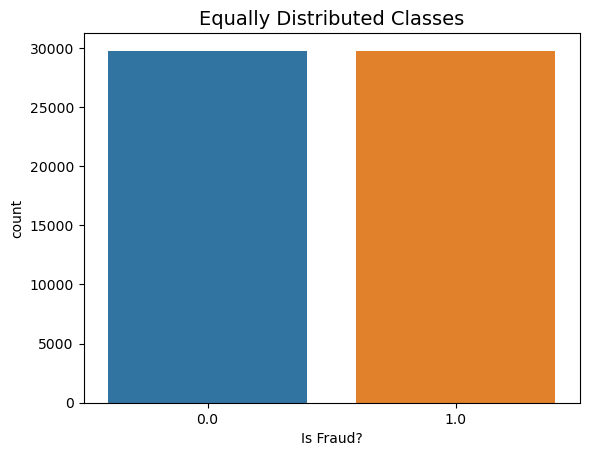

In [12]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Is Fraud?'].value_counts()/len(new_df))



sns.countplot(x = new_df['Is Fraud?'])
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Correlation Matrixes

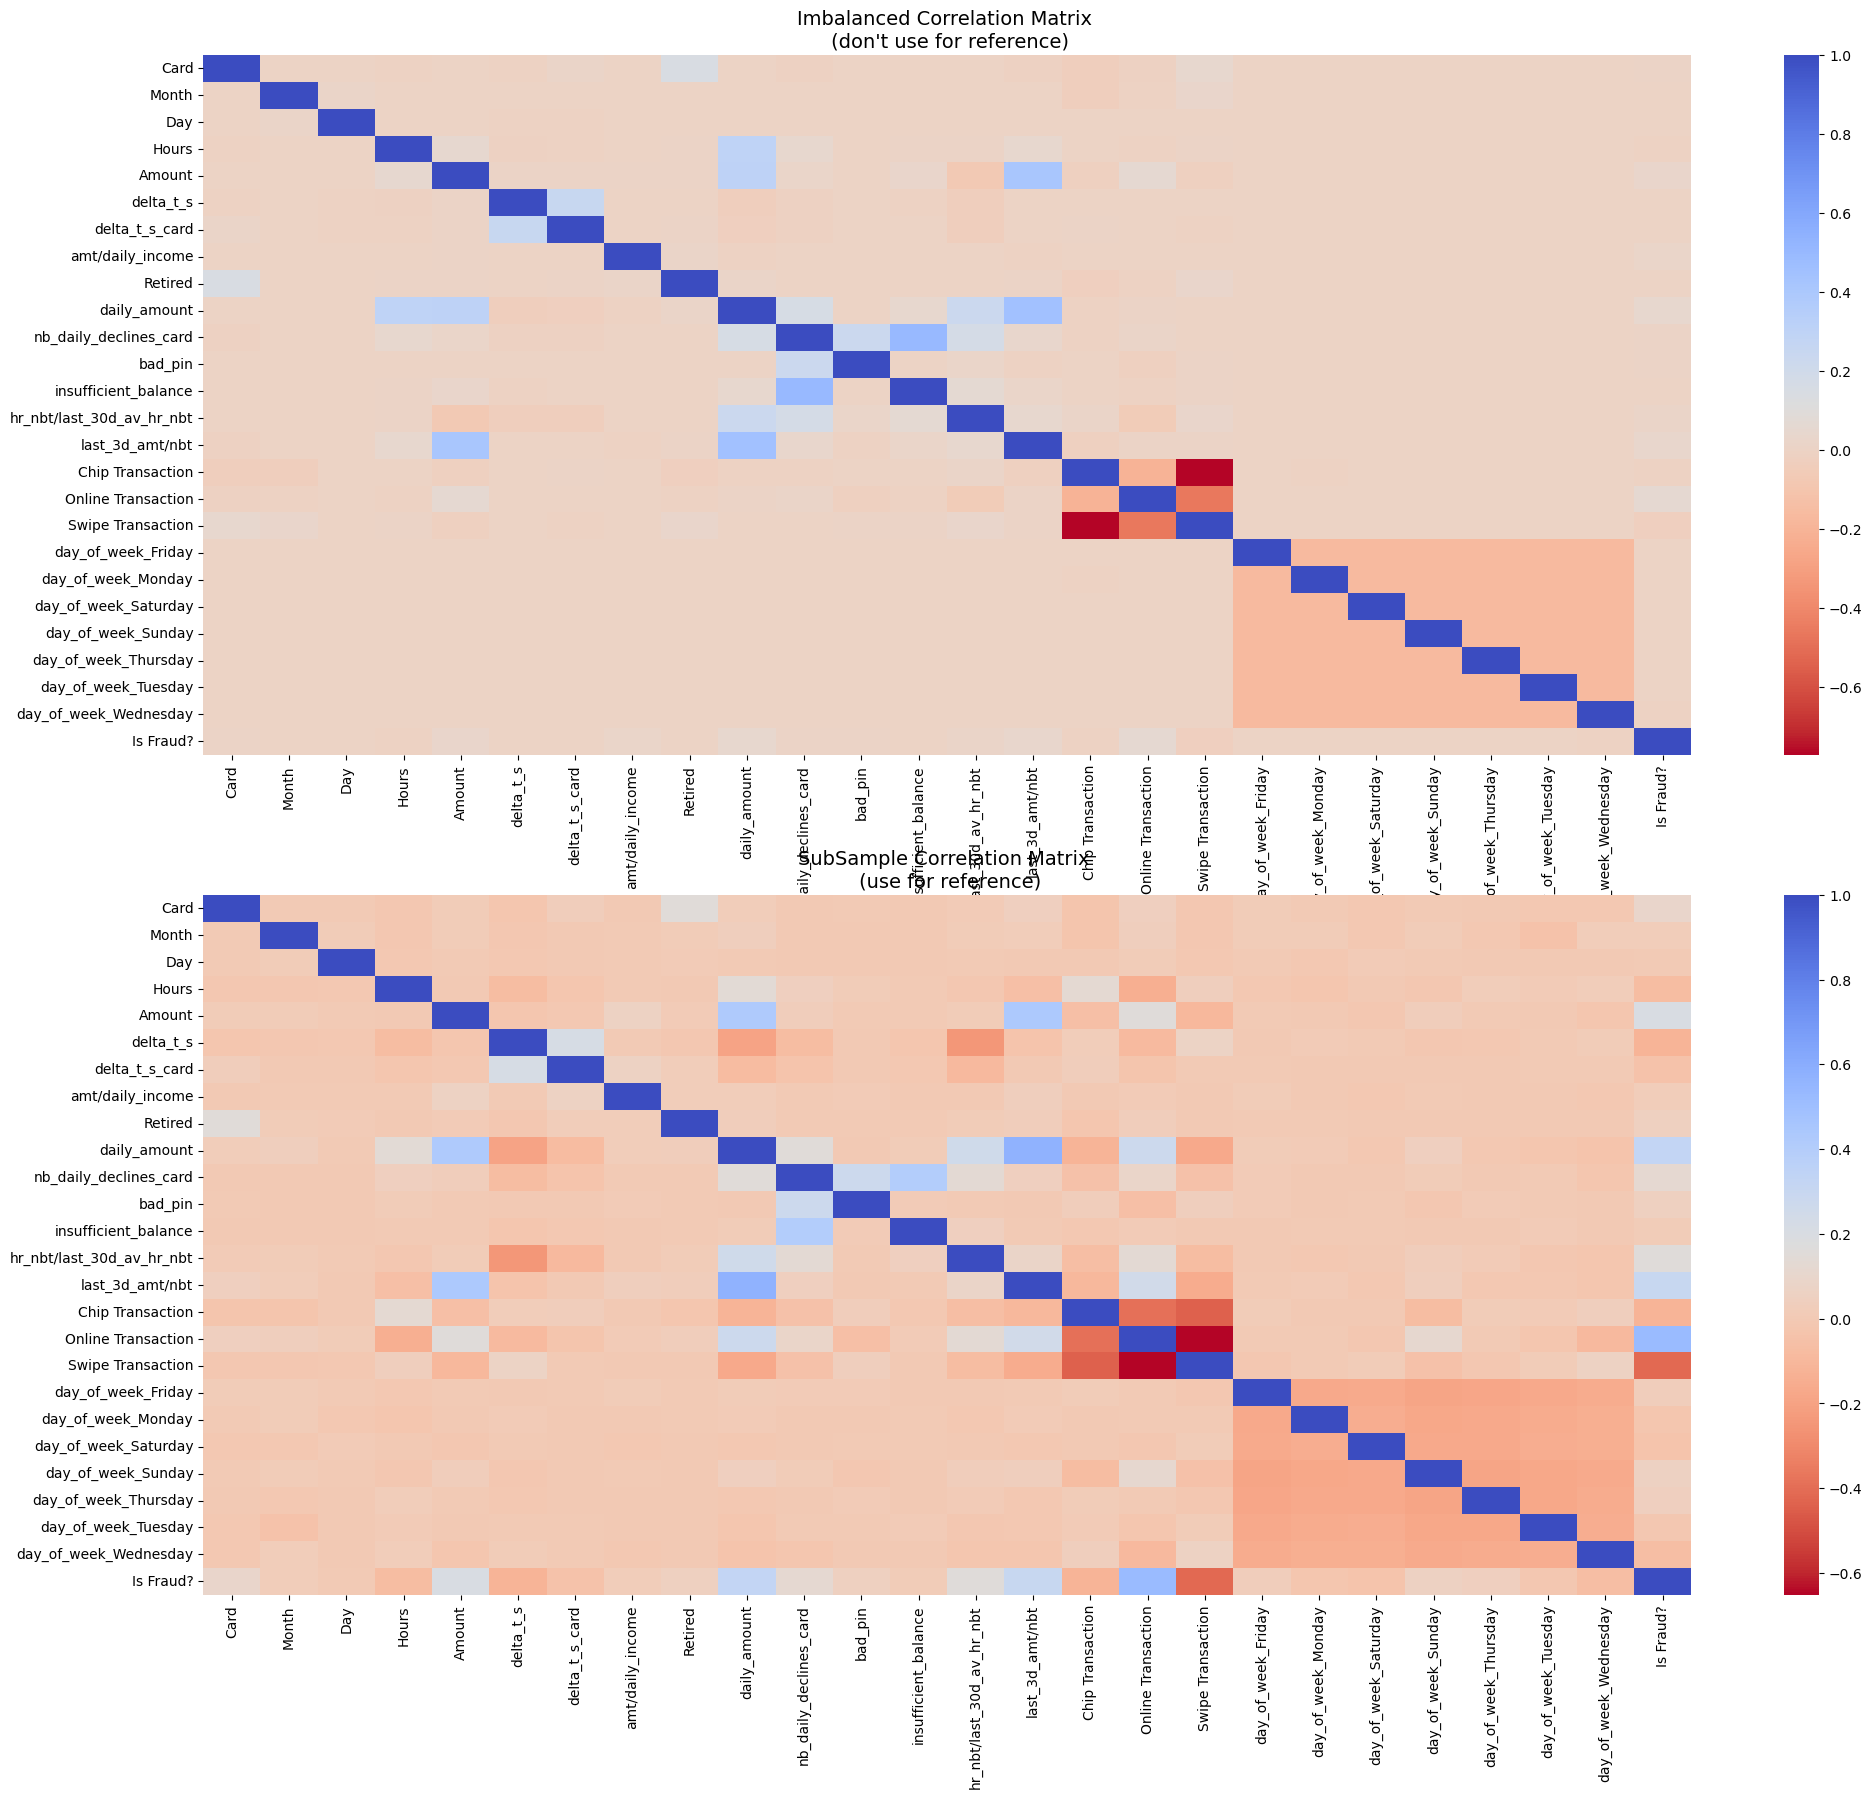

In [13]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df_cct.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

## Undersampling

In [14]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Is Fraud?', axis=1)
y = new_df['Is Fraud?']

In [15]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [20]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score

LogisticRegression().fit(X_train, y_train)
training_score = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Logistic Regression: Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Logistic Regression: Has a training score of 77.0 % accuracy score


## GridSearchCV

In [21]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_



In [23]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  77.48%


In [24]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")
        
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))

Logistic Regression:  0.8502487504141687


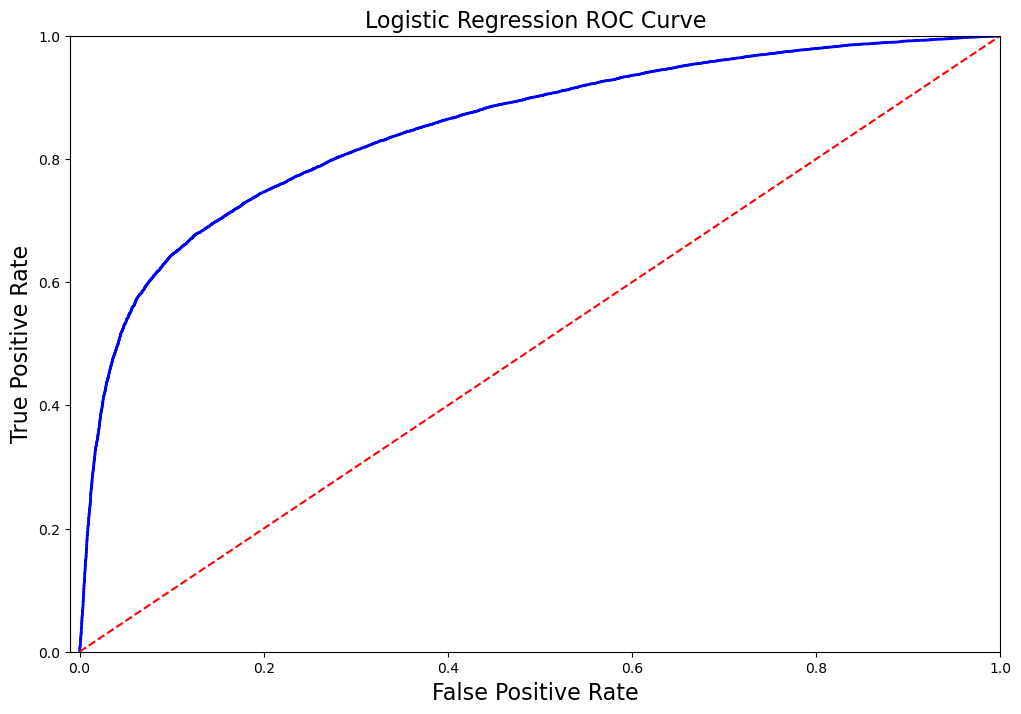

: 

In [26]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()